##  (Deep) CNNs for Image Colorization

In [2]:
import sys
import pandas as pd
import numpy as np
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import os
import math
import warnings
warnings.filterwarnings('ignore')
import keras

#### Used dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz. and further extracted the bird class, which has 6000 members.


In [3]:
cifar10 = keras.datasets.cifar10
# Downloading data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
#print( X_train.shape, y_train.shape, X_test.shape, y_train.shape)

In [39]:
X_train_re = X_train.reshape(-1, 32*32*3)
y_train_re = y_train.reshape(-1)
X_test_re = X_test.reshape(-1, 32*32*3)
y_test_re = y_test.reshape(-1)

##Birds are in class 2
X_train = X_train_re[y_train_re == 2].reshape(-1, 32, 32, 3)
y_train = y_train_re[y_train_re == 2]
X_test = X_test_re[y_test_re == 2].reshape(-1, 32, 32, 3)
y_test = y_test_re[y_test_re == 2]

print( X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5000, 32, 32, 3) (5000,)
(1000, 32, 32, 3) (1000,)


#####  Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements
#####  Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.6


In [31]:
X_df =np.concatenate((X_train, X_test))
y_df =np.concatenate((y_train, y_test))

print(X_df.shape,y_df.shape)

(6000, 32, 32, 3) (6000,)


original image:


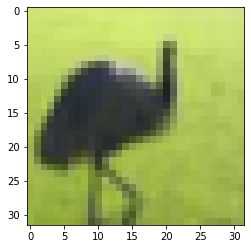

In [40]:
print("original image:")
plt.imshow(X_test[10])

In [7]:
from sklearn.cluster import KMeans

# X_df.reshape(-1, 3).shape
kmean = KMeans(n_clusters=4).fit(X_df.reshape(-1, 3))
center = kmean.cluster_centers_
label_pred = kmean.labels_

In [45]:
X_convert1 = X_df.reshape(-1, 3)
for i in range(len(label_pred)):
    X_convert1[i] = np.array (center[label_pred[i]], dtype=np.uint8)
X_convert1 = X_convert1.reshape(-1, 32, 32, 3)

1st pallet image:


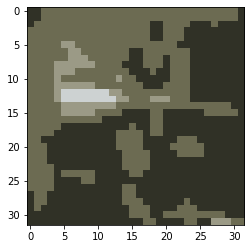

In [46]:
print("1st pallet image:")
plt.imshow(X_convert1[10])

In [10]:
# From the hw7 pdf, I take the suggestion to use a more contrastive pixel sample

# Navy , Red , Mint, and White
pallet2 = np.array([[0,0,128],[230,25,75],[170,255,195],[255,255,255]], dtype=np.uint8)

#dataset
X_convert2 = X_df.reshape(-1, 3)
for i in range(len(X_df.reshape(-1, 3))):
    X_convert2[i] = np.array (pallet2[label_pred[i]], dtype=np.uint8)
X_convert2 = X_convert2.reshape(-1, 32, 32, 3)

#test set
X_convert2_test = X_test.reshape(-1, 3)
for i in range(len( X_test.reshape(-1, 3))):
    X_convert2_test[i] = np.array(pallet2[label_pred[i]], dtype=np.uint8)
X_convert2_test = X_convert2_test.reshape(-1, 32, 32, 3)


2nd pallet image:


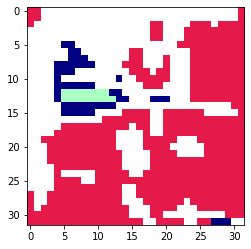

In [51]:
print("2nd pallet image:")
plt.imshow(X_convert2_test[10])

gray pallet image:


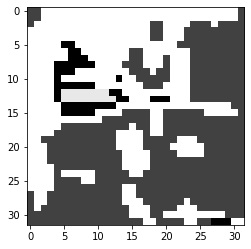

In [12]:
from skimage.color import rgb2gray

X_df_gr = np.array([rgb2gray(X_df[i]) for i in range(len(X_df))])

print ('gray pallet image:')
plt.imshow(X_df_gr[10], cmap=plt.cm.gray)

#### Setting up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers. 
- Use 5 × 5 filters and a softmax output layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. 
- Use a classification scheme, which means your output must determine one of the k = 4 color classes for each pixel in your grayscale image. Your input is a grayscale version of an image (32 × 32 × 1) and the output is 32 × 32 × 4. The output assigns one of the k = 4 colors to each of the 32 × 32 pixels; therefore, each of the pixels is classified into one of the classes [1 0 0 0], [0 1 0 0], [0 0 1 0], [0 0 0 1]. After each pixel is classified into one of the main colors, the RGB code of that color can be assigned to the pixel. For example, if the third main color 7 is [255 255 255] and pixel (32,32) of an image has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the (32,32) place in the output can be associated with [255 255 255]. The size of the output of the convolutional part, c1 × c2 depends on the size of the convolutional layers you choose and is a feature map, which is a matrix. 
- That matrix must be flattened or reshaped, i.e. must be turned into a vector of size c1c2 ×1, before it is fed to the MLP part. Choose the number of neurons in the first layer of the MLP (and any other hidden layers, if you are willing to have more than one hidden layer) yourself, but the last layer must have 32 × 32 × 4 = 4096 neurons, each of which represents a pixel being in one of the k = 4 classes. Add a softmax layer8 which will choose the highest value out of its k = 4 inputs for each of the 1024 pixels; therefore, the output of the MLP has to be reshaped into a 32 × 32 × 4 matrix, and to get the colored image, the RGB vector of each of the k = 4 classes has to be converted to the RGB vector, so an output image will be 32 × 32 × 3. Train at least for 5 epochs (30 epochs is strongly recommended).
- Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images

In [13]:
from keras import layers, models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [14]:
encoder = OneHotEncoder(handle_unknown='ignore')
label_true = [[0], [1], [2], [3]] # label onehot! 
encoder.fit(label_true)

y_encoded = encoder.transform(label_pred.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 4)
X_tr_gr, X_te_gr, y_tr_gr, y_te_gr = train_test_split(X_df_gr.reshape(-1, 32, 32, 1), y_encoded, test_size=0.17)

In [15]:
print(X_tr_gr.shape,y_tr_gr.shape)
print ( X_te_gr.shape, y_te_gr.shape)

(4979, 32, 32, 1) (4979, 32, 32, 4)
(1021, 32, 32, 1) (1021, 32, 32, 4)


In [16]:
#Building CNN
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size = (5,5), strides=(1,1), padding='same', input_shape = (32,32,1)))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(1,1), padding='same'))
model.add(layers.Conv2D(64, kernel_size = (5,5), strides=(1,1), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(1,1), padding='same'))
model.add(layers.Conv2D(64, kernel_size= (5,5), strides=(1,1), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(1,1), padding='same'))

#MLP - hidden
model.add(layers.Dense(32, activation='softmax'))
model.add(layers.Dense(4, activation='softmax'))


model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 32)      

In [17]:
# cnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fitting the data
result = model.fit(X_tr_gr, y_tr_gr, epochs=30, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3983 samples, validate on 996 samples
Epoch 1/30
3983/3983 [==============================] - 53s 13ms/step - loss: 1.1466 - accuracy: 0.6658 - val_loss: 1.0376 - val_accuracy: 0.7459
Epoch 2/30
3983/3983 [==============================] - 55s 14ms/step - loss: 0.9600 - accuracy: 0.7758 - val_loss: 0.8912 - val_accuracy: 0.7939
Epoch 3/30
3983/3983 [==============================] - 52s 13ms/step - loss: 0.8357 - accuracy: 0.8066 - val_loss: 0.7826 - val_accuracy: 0.8151
Epoch 4/30
3983/3983 [==============================] - 53s 13ms/step - loss: 0.7357 - accuracy: 0.8246 - val_loss: 0.6942 - val_accuracy: 0.8290
Epoch 5/30
3983/3983 [==============================] - 57s 14ms/step - loss: 0.6584 - accuracy: 0.8344 - val_loss: 0.6279 - val_accuracy: 0.8352
Epoch 6/30
3983/3983 [==============================] - 56s 14ms/step - loss: 0.5990 - accuracy: 0.8395 - val_loss: 0.5773 - val

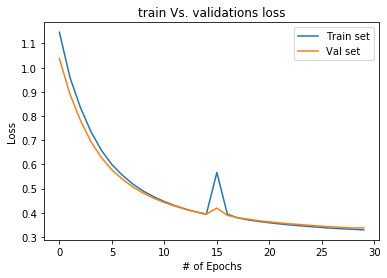

In [18]:
#Eval vs train loss 
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# of Epochs')
plt.legend(['Train set', 'Val set'], loc='upper right')
plt.title('train Vs. validations loss')
# plt.grid(True)
plt.show()

In [19]:
test_eval = model.evaluate(X_te_gr, y_te_gr)
print(test_eval)

1021/1021 [==============================] - 3s 3ms/step
[0.34178850781555625, 0.8362789750099182]


In [20]:
# plt.imshow(X_tr_gr.reshape(32, 32, 4)[1],  cmap=plt.cm.gray)

In [22]:
#X_te_gr.shape= 1021 
pred = model.predict(X_te_gr)
pred = pred.reshape(1021 * 32 * 32, 4)

img_pred = []
for idx in range(len(pred)):
    img_pred.append([int(cc) for cc in center[np.argmax(pred[idx])]])
img_pred = np.array(img_pred).reshape(-1, 32, 32, 3)

# plt.imshow(img_out[1])

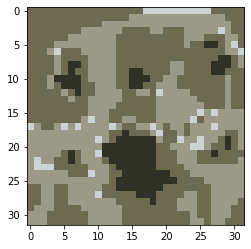

In [55]:
plt.imshow(img_pred[10], cmap=plt.cm.gray)

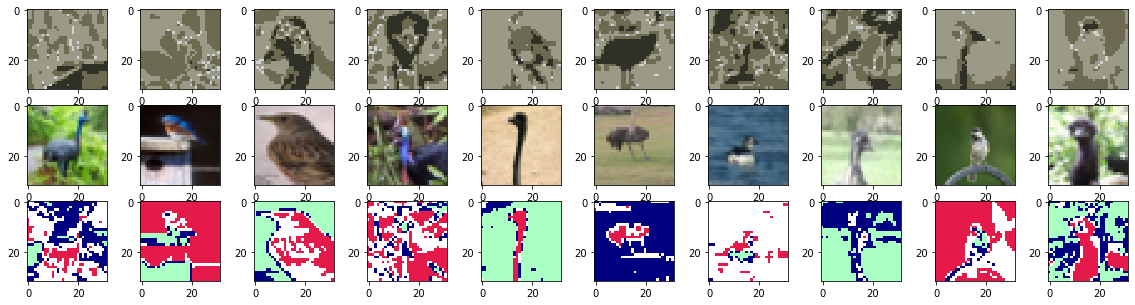

In [57]:
### predited images 
fig, axs = plt.subplots(3,10, figsize=(20, 5))
X_df =np.concatenate((X_train, X_test))

for i in range(10):

    # predicted image 
    test = img_pred[i]
    axs[0][i].imshow(test)
     
    # the actual - real image     
    real =X_df[i]
    axs[1][i].imshow(real)
     
    # gray-scaled picture [input of CNN]    
    real2 =X_convert2[i]
    axs[2][i].imshow(real2, cmap=plt.cm.gray)

##### Citation 
- https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html
- https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac
- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
- https://towardsdatascience.com/implementing-a-deep-neural-network-for-the-cifar-10-dataset-c6eb493008a5
- https://deepsense.ai/deep-learning-hands-on-image-classification/